# Protocol for analysis of labeled proteomics data
We recommend the following structure for describing the protocol and its example workflow. Below you can find an overview of required features of the protocol and its description and rules for best practices.

This is the link to the github repository of the protocol 
TODO add version!
https://github.com/ProtProtocols/biocontainer-jupyter

Link to docker image:



## Abstract

Labelled peptide mass spectrometry provides fast large-scale comparison of protein abundances over multiple conditions. To date, no one stop shop software solution exists that enables the common researcher to carry out the full analysis of the acquired raw data. Pipeline for this analysis have often been established in laboratories that are based on a combination of different software tools and in-house programs. Different and often new versions of the used tools and issues with the compatibility of apparently interoperable tools make it very difficult to ensure reproducible proteomics data analysis. We present a 100% reproducible software protocol to fully analyze data from one of the most popular types of proteomics experiments. The protocol is fully based on open source tools installed on a docker container, additionally providing a user-friendly and interactive browser interface for guidance of configuration and execution of the different operations. An example use case is provided that can be used for testing and adaption of own data sets. With this setup, analysis of labelled MS data will yield identical results on any computer that meets the computational bandwidth to run the analysis. 

(Provide a short description of the software protocol including broader context, functionality, use case and purpose.)


## Maintainer
Provide details about the protocol maintainer (e.g. email address and/or github username)

## Software
Specify links for documentation and tutorials of used software, source code, publications and use cases. Detail versions of each used software. Alternatively, provide links to the software descriptions in https://bio.tools where this information is available.

## Diagram
Provide a simple diagram of functionality of the workflow/software. We recommend using controlled vocabularies for input/output data types and file formats as well as provided operation of the tool(s). You can use http://edamontology.org terms for the description.

__TODO: example__

## System requirements
Fill in the following items:
Required hard disk space for docker image, input and output files: 

Required memory: 

Recommmended number of threads: 

## Example 
Presentation of well-documented instructions and commands to run the example use case. Depending on the use case and the software, provide link(s) to open the web service incorportated in the Docker image (e.g. 0.0.0.0:8080), bash commands to run programs from the command line and additional code for e.g. checking and visualizing the (intermediate) results. 

Instead of providing the instructions in this notebook, one can also provide a link to a notebook containing the example use case.

## More general use case (optional)
Provide link to notebook with a generalized use case that easily can be adapted to e.g. process different input data and concurrent parametrization.




# Example


In [50]:
%load_ext rpy2.ipython

The rpy2.ipython extension is already loaded. To reload it, use:
  %reload_ext rpy2.ipython


Specify parameters for database search and evaluation of identified peptide-spectrum matches:

In [51]:
import ipywidgets as widgets
from ipywidgets import VBox, Label
import sys, os
import subprocess
import psutil
import pandas as pd
from IPython.display import Javascript, display
import json

# create an empty class as a storage for all UI widgets
class SearchUI:
    def __init__(self):
        self.work_dir_select = widgets.Dropdown(options={'/data/': '/data/', 'Example files': '/home/biodocker/'}, 
                                                value='/home/biodocker/')
        self.work_dir_select.observe(observe_work_dir_select)
        
        self.precursor_tolerance = widgets.IntSlider(min=-10,max=30,step=1,value=20)
        self.fragment_tolerance = widgets.BoundedFloatText(min=0,max=200,value=0.05)
        self.fasta_db = widgets.Dropdown(options={"sp_human.fasta": "IN/sp_human.fasta"})
        
        self.generate_decoy = widgets.Checkbox(value=True, description="Generate decoy sequences")
        
        # TODO  needs table to describe labeling formats
        self.labelling = widgets.Dropdown(options=
                          {'TMT6': 'TMT 6-plex of K,TMT 6-plex of peptide N-term',
                           'TMT10': 'TMT 10-plex of K,TMT 10-plex of peptide N-term',
                           'iTRAQ4 (Y fixed)': 'iTRAQ 4-plex of K,iTRAQ 4-plex of Y,iTRAQ 4-plex of peptide N-term',
                           'iTRAQ4 (Y variable)': 'iTRAQ 4-plex of K,iTRAQ 4-plex of peptide N-term',
                           'iTRAQ8 (Y fixed)': 'iTRAQ 8-plex of K,iTRAQ 8-plex of Y,iTRAQ 8-plex of peptide N-term',
                           'iTRAQ8 (Y variable)': 'iTRAQ 8-plex of K,iTRAQ 8-plex of peptide N-term'},
                      value='TMT 10-plex of K,TMT 10-plex of peptide N-term')
        
        self.missed_cleavages = widgets.IntSlider(min=0,max=10,step=1,value=1)
        self.fixed_ptms = widgets.Dropdown(options=["Carbamidomethylation of C","None"])

        # PTMs
        self.var_ptms = widgets.SelectMultiple(
            options=["Oxidation of M",
                     "Phosphorylation of STY",
                     "Acetylation of peptide N-term",
                     "Acetylation of protein N-term"],
            value=['Oxidation of M'])
        
        self.spectra_dir = widgets.Dropdown(options={"IN": "IN"})

        # ww = widgets.Checkbox(description="Decoy")

        self.exp_des_button = widgets.Button(
            description='Enter design',
            disabled=False,
            button_style='', # 'success', 'info', 'warning', 'danger' or ''
            tooltip='Enter experimental design',
            icon='check'
        )

        self.exp_des_button.on_click(show_exp_design)
        
        
    def updateFastaFiles(self, workdir):
        # get all FASTA files
        fasta_files = [file for file in os.listdir(workdir) if file[-6:] == ".fasta"]
        
        # also search all subdirectories for FASTA files
        for d in os.listdir(workdir):
            d_path = os.path.join(workdir, d)
            if os.path.isdir(d_path) and d[0] != ".":
                fasta_files += [os.path.join(d, file) for file in os.listdir(d_path) if file[-6:] == ".fasta"]
        
        # create the dict to add as values to the control
        file_list = dict()
        sel_value = None
        
        for f in fasta_files:
            file_list[f] = os.path.join(os.path.abspath(workdir), f)
            if sel_value is None:
                sel_value = os.path.join(os.path.abspath(workdir), f)
        
        self.fasta_db.options = file_list
        self.fasta_db.value = sel_value
        
        # update the list of possible peaklist directories
        directories = [d for d in os.listdir(workdir) if os.path.isdir(os.path.join(workdir, d)) and d[0] != "."]
        
        dir_list = dict()
        
        for d in directories:
            dir_list[d] = os.path.join(os.path.abspath(workdir), d)
            
        self.spectra_dir.options = dir_list
        
        if "IN" in dir_list:
            self.spectra_dir.value = dir_list["IN"]
        
        
    def display(self):
        self.updateFastaFiles(self.work_dir_select.value)
        
        settings_box = VBox([Label('Working directory'), self.work_dir_select,
                             Label('Precursor tolerance (ppm):'), self.precursor_tolerance, 
                             Label('Fragment ion tolerance (da):'), self.fragment_tolerance,
                             Label('Fasta file (database, must NOT contain decoy sequences):'), self.fasta_db,
                             self.generate_decoy,
                             Label('Quantification method:'), self.labelling,
                             Label('Number of miscleavages;'), self.missed_cleavages,
                             Label('Further fixed modifications'), self.fixed_ptms,
                             Label('Further variable modifications (Hold Ctrl to select multiple)'), self.var_ptms,
                             Label('Folder for spectra files (files need to be mgf)'), self.spectra_dir,
                             Label('Note: When entering the experimental design, the working directory and '
                                   'labelling method can no longer be changed.'),
                             self.exp_des_button])

        display(settings_box)
        
    def save_config(self, file):
        """
        Save all configurations set by the user into a JSON formatted
        text file.
        :param: file: The name of the target file to use. Will be overwritten if it exists.
        """
        search_config = dict()
        search_config["work_dir"] = self.work_dir_select.value
        search_config["precursor_tolerance"] = self.precursor_tolerance.value
        search_config["fragment_tolerance"] = self.fragment_tolerance.value
        search_config["fasta_file"] = self.fasta_db.value
        search_config["generate_decoy"] = self.generate_decoy.value
        search_config["quantification_method"] = self.labelling.value
        search_config["missed_cleavages"] = self.missed_cleavages.value
        search_config["fixed_mods"] = self.fixed_ptms.value
        search_config["var_mods"] = self.var_ptms.value
        
        json_string = json.dumps(search_config)
        
        with open(file, "w") as writer:
            writer.write(json_string + "\n")
        

class ExpDesignUI:
    def __init__(self, labelling_technique, result_file):
        """
        Generates all use interface objects as member variables.
        
        :param labelling_technique: The labelling method used.
        """
        self.result_file = result_file
        
        # always expect two groups
        self.group1_name = widgets.Text(placeholder = "Treatment", description = "Group 1:")
        self.group2_name = widgets.Text(placeholder = "Control", description = "Group 2:")
        
        self.channels = {
            'TMT6': ["126", "127", "128", "129", "130", "131"],
            'TMT10': ["126", "127N", "127C", "128N", "128C", "129N", "129C", "130N", "130C", "131"],
            'iTRAQ4': ["114", "115", "116", "117"],
            'iTRAQ8': ["113", "114", "115", "116", "117", "118", "119", "121"]
        }
        
        # removed everything in string labellign_technique after space 
        if labelling_technique.split(" ")[0] not in self.channels:
            raise Exception("Unknown labelling technique: '" + labelling_technique + "'")
            
        self.labelling_technique = labelling_technique.split(" ")[0]
            
        # generate the textfields for the channels
        self.channel_names = list()
        
        for channel in self.channels[self.labelling_technique]:
            self.channel_names.append(widgets.Text(description = channel, placeholder = "Sample " + channel))
            
        # add select boxes to select the experimental group
        self.group_selects = list()
        
        for channel in self.channels[self.labelling_technique]:
            self.group_selects.append(widgets.Dropdown(options = ["Group 1", "Group 2"], value = "Group 1"))
            
        self.save_button = widgets.Button(
            description='Save design',
            disabled=False,
            button_style='', # 'success', 'info', 'warning', 'danger' or ''
            tooltip='Save the experimental design',
            icon='check'
        )

        self.save_button.on_click(self.save_design)
        
        self.search_button_visible = False

    def display(self):
        widget_list = [widgets.Label("Treatment group names:"), self.group1_name, self.group2_name,
                       widgets.Label("Sample names (per channel):")]
        
        for i in range(0, len(self.channel_names)):
            widget_list.append(widgets.HBox([self.channel_names[i], self.group_selects[i]]))
            
        widget_list.append(self.save_button)
        
        widget_box = VBox(widget_list)
        
        display(widget_box)
        
    def save_design(self, button):
        # get all names
        sample_names = [s.value if s.value != "" else s.placeholder for s in self.channel_names]
        sample_group = [g.value for g in self.group_selects]
        channel_names = self.channels[self.labelling_technique]
        
        # TODO: make sure all sample names are filled in
        
        # replace the group names
        for i in range(0, len(sample_group)):
            if sample_group[i] == "Group 1":
                sample_group[i] = self.group1_name.value if self.group1_name.value != "" else self.group1_name.placeholder
            elif sample_group[i] == "Group 2":
                sample_group[i] = self.group2_name.value if self.group2_name.value != "" else self.group2_name.placeholder
        
        design_data = pd.DataFrame(
            data={'channel': channel_names, 'sample_name' : sample_names, 'sample_group': sample_group},
        )
        
        design_data.to_csv(path_or_buf=self.result_file, sep="\t", index=False)
        
        # add the run search button
        if not self.search_button_visible:
            self.search_button = widgets.Button(
                description='Run search',
                disabled=False,
                button_style='', # 'success', 'info', 'warning', 'danger' or ''
                tooltip='Run the search',
                icon='check'
            )
            
            self.search_button.on_click(run_search)

            search_box = VBox([self.search_button])
            display(search_box)
            
            self.search_button_visible = True
      
        
def adapt_mgf_titles(filenames):
    """
    This function changes all MGF titles to [filename].[spec index]
    :param: filenames: Filenames of the MGF files to change
    """
    for filename in filenames:
        with open(filename, "r") as reader:
            clean_name = os.path.basename(filename).replace(" ", "_")
            # MGF index reference in PSI standard is 1-based
            cur_index = 1
            
            with open(filename + ".tmp", "w") as writer:
                for line in reader:
                    if line[0:6] == "TITLE=":
                        writer.write("TITLE=" + clean_name + "." + str(cur_index) + "\n")
                        cur_index += 1
                    else:
                        writer.write(line)
                        
        # backup the original file
        os.rename(filename, filename + ".org")
        os.rename(filename + ".tmp", filename)
        
        
def filter_mgf_peaks(filenames, min_mz=100, max_mz=150):
    """
    Removes all peaks from the passed mgf files that are below min_mz or
    above max_mz. The results are written to files with the same name but
    ".filtered" appended to the name.
    :param: filenames: List of filenames to process.
    :param: min_mz: Minimum m/z a peak must have to be kept
    :param: max_mz: Maximum m/z a peak may have to be kept
    """
    for filename in filenames:
        with open(filename, "r") as reader:
            with open(filename + ".filtered", "w") as writer:
                for line in reader:
                    # check if it's a peak
                    if line[0].isdigit():
                        sep_index = line.find(" ")
                        if sep_index < 0:
                            sep_index = line.find("\t")
                        if sep_index < 0:
                            raise Exception("Invalid peak definition found: " + line + 
                                            ". Failed to filter file " + filename)
                            
                        mz = float(line[:sep_index])
                            
                        # ignore any non-matching peaks
                        if mz < min_mz or mz > max_mz:
                            continue
                            
                    # copy the line
                    writer.write(line)
    

def show_exp_design(button):
    """
    Display the experimental design dialog. This function is called
    through the button at the end of the SearchUI dialog
    """
    global searchUI, expDesignUI
    
    work_dir = os.path.abspath(os.path.join(searchUI.work_dir_select.value, "OUT"))
    
    if not os.path.isdir(work_dir):
        os.mkdir(work_dir)
    
    # disable the exp_design button and the labelling method
    searchUI.exp_des_button.disabled = True
    searchUI.labelling.disabled = True
    searchUI.work_dir_select.disabled = True
    
    # get the currently selected labelling method
    labelling_method = list(searchUI.labelling.options.keys())[searchUI.labelling.index]

    expDesignUI = ExpDesignUI(labelling_method, result_file=os.path.join(work_dir, "exp_design.tsv"))
    expDesignUI.display() 
    
    
def run_search(button):
    global searchUI, result_file
    
    # get the free memory in MB
    free_mem = round(psutil.virtual_memory().available / 1024 / 1024)
    # if there's more than 1G available, leave 1G for other tasks
    if free_mem > 1000:
        free_mem -= 1000
    
    # make sure all required fields were selected
    if searchUI.work_dir_select.value is None:
        print("Error: No working directory selected")
        return
    
    if searchUI.fasta_db.value is None:
        print("Error: No FASTA file selected")
        return
    
    # create the directory paths to work in
    peaklist_dir = os.path.abspath(searchUI.spectra_dir.value)
    
    if not os.path.isdir(peaklist_dir):
        raise Exception("Invalid peak list directory selected: " + peaklist_dir + " does not exist.")
    
    peptide_shaker_jar = "/home/biodocker/bin/PeptideShaker-1.16.17/PeptideShaker-1.16.17.jar"
    searchgui_jar = "/home/biodocker/bin/SearchGUI-3.2.20/SearchGUI-3.2.20.jar"
    work_dir = os.path.abspath(os.path.join(searchUI.work_dir_select.value, "OUT"))
    exp_design_file = os.path.join(work_dir, "exp_design.tsv")
    
    # the searches should be performed in the "OUT" directory
    if not os.path.isdir(work_dir):
        os.mkdir(work_dir)
    else:
        # make sure all temporary files are gone
        tmp_files =  ["AllQuantPSMs.RData", "AllQuantPSMs.csv", "experiment.cpsx", "experiment1_test_1_Extended_PSM_Report.txt",
                     "search.par", "searchgui_out.zip"]
        for tmp_file in tmp_files:
            complete_name = os.path.join(work_dir, tmp_file)
            if os.path.isfile(complete_name):
                os.remove(complete_name)
    
    # -------------------------------------
    # Save the settings
    searchUI.save_config(os.path.join(work_dir, "search_settings.json"))
    
    # -------------------------------------
    # Fix all MGF titles
    print("Adapting MGF titles...")
    mgf_filenames = [os.path.join(peaklist_dir, f) for f in os.listdir(peaklist_dir) if f[-4:].lower() == ".mgf"]
    adapt_mgf_titles(mgf_filenames)
    print(mgf_filenames)
    
    print("Extracting reporter peaks...")
    filter_mgf_peaks(mgf_filenames)
    
        
    # -------------------------------------
    # Generate the decoy database
    
    if searchUI.generate_decoy.value == True:
        print("Creating decoy database...")

        # create the decoy database
        subprocess.run(["java", "-Xmx" + str(free_mem) + "M", "-cp", searchgui_jar, 
                       "eu.isas.searchgui.cmd.FastaCLI", "-in", searchUI.fasta_db.value, "-decoy"], check=True,
                       cwd=work_dir,
                       stdout=subprocess.PIPE, stderr=subprocess.PIPE)

        # get the filename of the decoy database
        database_file = os.path.abspath(searchUI.fasta_db.value)[:-6] + "_concatenated_target_decoy.fasta"
    else:
        # simply use the selected database file
        database_file = os.path.abspath(searchUI.fasta_db.value)
    
    if not os.path.isfile(database_file):
        raise Exception("Failed to find generated decoy database")
        
    # ---------------------------------------------
    # Create the search parameter file
        
    # build the arguments to create the parameter file
    param_file = os.path.join(work_dir, "search.par")
    
    # remove any old parameters
    if os.path.isfile(param_file):
        os.remove(param_file)
    
    search_args = ["java", "-Xmx" + str(free_mem) + "M", "-cp", searchgui_jar,
                   "eu.isas.searchgui.cmd.IdentificationParametersCLI",
                   "-out", param_file]
    
    # precursor tolerance
    search_args.append("-prec_tol")
    search_args.append(str(searchUI.precursor_tolerance.value))
    # fragment tolerance
    search_args.append("-frag_tol")
    search_args.append(str(searchUI.fragment_tolerance.value))
    # fixed mods
    # TODO: labelling cannot always be set as fixed mod???
    fixed_mod_string = str(searchUI.labelling.value) + "," + str(searchUI.fixed_ptms.value)
    search_args.append("-fixed_mods")
    search_args.append(fixed_mod_string)
    # database
    search_args.append("-db")
    search_args.append(database_file)
    # missed cleavages
    search_args.append("-mc")
    search_args.append(str(searchUI.missed_cleavages.value))
    
    # var mods
    labelling_method = list(searchUI.labelling.options.keys())[searchUI.labelling.index]
    
    if len(searchUI.var_ptms.value) > 0 or ("Y variable" in labelling_method) :
        search_args.append("-variable_mods")
        var_mod_list = list()
        
        for var_mod in searchUI.var_ptms.value:
            if var_mod == "Phosphorylation of STY":
                var_mod_list += ["Phosphorylation of S", "Phosphorylation of T", "Phosphorylation of Y"]
            else:
                var_mod_list.append(var_mod)
        if (labelling_method == "iTRAQ4 (Y variable)"):
            var_mod_list.append("iTRAQ 4-plex of Y")
        if (labelling_method == "iTRAQ8 (Y variable)"):
            var_mod_list.append("iTRAQ 8-plex of Y")
        
                
        search_args.append(",".join(var_mod_list))
        
    # create the search parameter file
    print("Creating search parameter file...")
    # print(" ".join(search_args))
    subprocess.run(search_args, check=True, cwd=work_dir, stdout=subprocess.PIPE, stderr=subprocess.PIPE)
    
    if not os.path.isfile(param_file):
        raise Exception("Failed to create search parameters")
        
    # ------------------------------------------------
    # Run the search
    print("Running search...")
    # TODO: create list of spectrum files - or the folder
    spectrum_files = peaklist_dir
    print("  Searching files in " + spectrum_files)
    search_process = subprocess.run(["java", "-Xmx" + str(free_mem) + "M", "-cp", searchgui_jar,
                    "eu.isas.searchgui.cmd.SearchCLI", "-spectrum_files", spectrum_files,
                    "-output_folder", work_dir, "-id_params", param_file,
                    "-xtandem", "0", "-msgf", "1", "-comet", "0", "-ms_amanda", "0", 
                    "-myrimatch", "0", "-andromeda", "0", "-omssa", "0", "-tide", "0"],
                    check=False, cwd=work_dir, stdout=subprocess.PIPE, stderr=subprocess.STDOUT, universal_newlines=True)
    
    if search_process.returncode != 0:
        print(search_process.stdout)
        raise Exception("Search process failed.")
    
    print("Search completed.")
    
    # -------------------------------------------------
    # Run PeptideShaker
    print("Processing result using PeptideShaker...")
    peptide_shaker_result_file = os.path.join(work_dir, "experiment.cpsx")

    peptide_shaker_process = subprocess.run(["java", "-Xmx" + str(free_mem) + "M", "-cp", peptide_shaker_jar,
                    "eu.isas.peptideshaker.cmd.PeptideShakerCLI",
                    "-useGeneMapping", "0",
                    "-experiment", "experiment1",
                    "-sample", "test",
                    "-replicate", "1",
                    "-identification_files", work_dir,
                    "-out", peptide_shaker_result_file,
                    "-id_params", param_file,
                    "-spectrum_files", spectrum_files],
                    check=False, cwd=work_dir, stdout=subprocess.PIPE, stderr=subprocess.STDOUT, universal_newlines=True)
    
    if peptide_shaker_process.returncode != 0:
        print(peptide_shaker_process.stdout)
        raise Exception("Failed to run PeptideShaker")

    if not os.path.isfile(peptide_shaker_result_file):
        raise Exception("Failed to process result file.")
      
    # ---------------------------------------------------
    # create TSV output files
    print("Converting result to TSV format...")
    conversion_process = subprocess.run(["java", "-Xmx" + str(free_mem) + "M", "-cp", peptide_shaker_jar,
                  "eu.isas.peptideshaker.cmd.ReportCLI",
                  "-in", peptide_shaker_result_file,
                  "-out_reports", work_dir,
                  "-reports", "8"],
                  check=False, cwd=work_dir, stdout=subprocess.PIPE, stderr=subprocess.STDOUT, universal_newlines=True)
    
    if conversion_process.returncode != 0:
        print(conversion_process.stdout)
        raise Exception("Conversion process failed")
    
    result_file=os.path.join(work_dir, "experiment1_test_1_Extended_PSM_Report.txt")
    
    if not os.path.isfile(result_file):
        raise Exception("Error: Conversion failed")
        
    # create parameter list as input for R script
    global Rinput
    Rinput = [searchUI.labelling.value, searchUI.spectra_dir.value, work_dir]
    
    print("Done.") 
    
    on_search_completed()

    
def on_search_completed():
    """
    This function is called once the search is successfully complete.
    """
    global Rinput, expDesignUI
    
    # disable previous steps
    expDesignUI.search_button.disabled = True
    expDesignUI.save_button.disabled = True
    
    # add the new button to run the R scripts
    run_quant_button = widgets.Button(
        description="Run quantification and peptide inference",
        layout=widgets.Layout(width='30%'))
    
    run_quant_button.on_click(run_next_cells)
    display(run_quant_button)

    
def run_next_cells(button):
    # Run the javascript code to launch the next cell
    display(
        Javascript('IPython.notebook.execute_cell_range(IPython.notebook.get_selected_index()+1, IPython.notebook.get_selected_index()+2)'))
    
    
def observe_work_dir_select(change):
    global work_dir_select
    if change['type'] == "change" and change['name'] == "value":
        # update the required UI controls
        searchUI.updateFastaFiles(change["new"])

# -------------------
# Code to create the UI
# --------------------
result_file=None
work_dir=None
peaklist_dir=os.path.abspath("IN")

searchUI = SearchUI()
searchUI.display()

VBox(children=(Label(value='Working directory'), Dropdown(options={'Example files': '/home/biodocker/', '/data/': '/data/'}, value='/home/biodocker/'), Label(value='Precursor tolerance (ppm):'), IntSlider(value=20, max=30, min=-10), Label(value='Fragment ion tolerance (da):'), BoundedFloatText(value=0.05, max=200.0), Label(value='Fasta file (database, must NOT contain decoy sequences):'), Dropdown(options={'IN/sp_human.fasta': '/home/biodocker/IN/sp_human.fasta', 'IN/sp_human_concatenated_target_decoy.fasta': '/home/biodocker/IN/sp_human_concatenated_target_decoy.fasta'}, value='/home/biodocker/IN/sp_human.fasta'), Checkbox(value=True, description='Generate decoy sequences'), Label(value='Quantification method:'), Dropdown(index=4, options={'iTRAQ4 (Y fixed)': 'iTRAQ 4-plex of K,iTRAQ 4-plex of Y,iTRAQ 4-plex of peptide N-term', 'iTRAQ4 (Y variable)': 'iTRAQ 4-plex of K,iTRAQ 4-plex of peptide N-term', 'TMT6': 'TMT 6-plex of K,TMT 6-plex of peptide N-term', 'iTRAQ8 (Y variable)': 'iTRAQ 8-plex of K,iTRAQ 8-plex of peptide N-term', 'TMT10': 'TMT 10-plex of K,TMT 10-plex of peptide N-term', 'iTRAQ8 (Y fixed)': 'iTRAQ 8-plex of K,iTRAQ 8-plex of Y,iTRAQ 8-plex of peptide N-term'}, value='TMT 10-plex of K,TMT 10-plex of peptide N-term'), Label(value='Number of miscleavages;'), IntSlider(value=1, max=10), Label(value='Further fixed modifications'), Dropdown(options=('Carbamidomethylation of C', 'None'), value='Carbamidomethylation of C'), Label(value='Further variable modifications (Hold Ctrl to select multiple)'), SelectMultiple(index=(0,), options=('Oxidation of M', 'Phosphorylation of STY', 'Acetylation of peptide N-term', 'Acetylation of protein N-term'), value=('Oxidation of M',)), Label(value='Folder for spectra files (files need to be mgf)'), Dropdown(options={'IN': '/home/biodocker/IN', 'R': '/home/biodocker/R', 'LOG': '/home/biodocker/LOG', 'OUT': '/home/biodocker/OUT', 'bin': '/home/biodocker/bin', 'misc': '/home/biodocker/misc'}, value='/home/biodocker/IN'), Label(value='Note: When entering the experimental design, the working directory and labelling method can no longer be changed.'), Button(description='Enter design', icon='check', style=ButtonStyle(), tooltip='Enter experimental design')))

VBox(children=(Label(value='Treatment group names:'), Text(value='', description='Group 1:', placeholder='Treatment'), Text(value='', description='Group 2:', placeholder='Control'), Label(value='Sample names (per channel):'), HBox(children=(Text(value='', description='126', placeholder='Sample 126'), Dropdown(options=('Group 1', 'Group 2'), value='Group 1'))), HBox(children=(Text(value='', description='127N', placeholder='Sample 127N'), Dropdown(options=('Group 1', 'Group 2'), value='Group 1'))), HBox(children=(Text(value='', description='127C', placeholder='Sample 127C'), Dropdown(options=('Group 1', 'Group 2'), value='Group 1'))), HBox(children=(Text(value='', description='128N', placeholder='Sample 128N'), Dropdown(options=('Group 1', 'Group 2'), value='Group 1'))), HBox(children=(Text(value='', description='128C', placeholder='Sample 128C'), Dropdown(options=('Group 1', 'Group 2'), value='Group 1'))), HBox(children=(Text(value='', description='129N', placeholder='Sample 129N'), Dropdown(options=('Group 1', 'Group 2'), value='Group 1'))), HBox(children=(Text(value='', description='129C', placeholder='Sample 129C'), Dropdown(options=('Group 1', 'Group 2'), value='Group 1'))), HBox(children=(Text(value='', description='130N', placeholder='Sample 130N'), Dropdown(options=('Group 1', 'Group 2'), value='Group 1'))), HBox(children=(Text(value='', description='130C', placeholder='Sample 130C'), Dropdown(options=('Group 1', 'Group 2'), value='Group 1'))), HBox(children=(Text(value='', description='131', placeholder='Sample 131'), Dropdown(options=('Group 1', 'Group 2'), value='Group 1'))), Button(description='Save design', icon='check', style=ButtonStyle(), tooltip='Save the experimental design')))

In [4]:
%%R -i Rinput

## assuming that the computer allows min. 4 threads
NumThreads <- 4

print(Rinput)
#stop()

# reading parameters
labeling <- Rinput[[1]]
inputDir <- Rinput[[2]]

# library causes the execution to fail if the library is missing
suppressWarnings(suppressMessages(library(lattice)))
suppressWarnings(suppressMessages(library(stringr)))
suppressWarnings(suppressMessages(library(mzID)))
#suppressWarnings(suppressMessages(library(matrixStats)))
#suppressWarnings(suppressMessages(library(venneuler)))
suppressWarnings(suppressMessages(library(MSnbase)))

# warnings as stdout
sink(stdout(), type = "message")

# Maybe TODO: Add option to provide mzML directly

print(inputDir)
setwd(inputDir)

## Folder names for different runs (e.g. different replicates, ...)
samples <- s <- c(".")
PSMDat <- PepDat <- ProtDat <- list()
for (s in samples) {
  
  ## Organize technical runs in the same folder
  # filenames
  ident_files <- list.files(paste("/home/biodocker/OUT/",s,sep=""),pattern="Extended_PSM_Report.txt$",full.names=T)
  #mzML_files <- list.files(s,pattern=".mzML$",full.names = T)
  #mgf_files <- list.files(s,pattern="_noquote.mgf$",full.names = T)
  mgf_files <- list.files(s,pattern="mgf.filtered$",full.names = T)
  
  # TODO: FDR as global parameter
  # process the input files
  max.fdr <- 0.01
  
  # translate into labeling method descriptors
  quant.methods <- cbind(c("TMT 10-plex of K,TMT 10-plex of peptide N-term","TMT 6-plex of K,TMT 6-plex of peptide N-term",
                           "iTRAQ 4-plex of K,iTRAQ 4-plex of Y, iTRAQ 4-plex of peptide N-term",
                           "iTRAQ 8-plex of K,iTRAQ 8-plex of Y,iTRAQ 8-plex of peptide N-term",
                          "iTRAQ 4-plex of K,iTRAQ 4-plex of peptide N-term",
                           "iTRAQ 8-plex of K,iTRAQ 8-plex of peptide N-term"),
                         c("TMT10","TMT6","iTRAQ4","iTRAQ8","iTRAQ4", "iTRAQ8"))
    if(is.null(quant.methods[quant.methods[,1] == labeling,2])) {
        stop("Error: labeling method not available")
    }
  quant.method <- get(quant.methods[quant.methods[,1] == labeling,2])
   
    
   ## TODO read from experimental design
  class.labels <- c("A", "B", "C", "D", "E", "F", "G", "H", "I", "J")
  args <- commandArgs(trailingOnly = TRUE)
  
  if (is.null(ident_files)) {
    stop("Error: No identification files")
  }

      if (is.null(mgf_files)) {
    stop("Error: No spectrum files")
  }

    
  if (!file.exists(ident_files)) {
    stop("Error: Cannot find identification files ", ident_files)
  }
  for (mgf_file in mgf_files) {
    if (!file.exists(mgf_file)) {
      stop("Error: Cannot find mgf file ", mgf_file)
    }
  }
  
  psms <- read.csv(ident_files, sep = "\t",stringsAsFactors = F)
  
  if (! "Decoy" %in% names(psms)) {
    stop("Error: No decoy information available in output file")
  }
  
  print(paste("Loaded",nrow(psms), "PSMs"))
  
  # ---- Confidence filter ----
  psms <- psms[order(psms[, "Confidence...."], decreasing = T), ]
  decoy.psms <- which(psms[, "Decoy"] == "1")
  
  decoy.count <- 0
  
  for (decoy.index in decoy.psms) {
    decoy.count <- decoy.count + 1
    target.count <- decoy.index - decoy.count
    
    cur.fdr <- (decoy.count * 2) / (decoy.count + target.count)
    
    if (cur.fdr > max.fdr) {
      # filter
      psms <- psms[1:decoy.index - 1,]
      break
    }
  }
  
print(paste0("Filtered ", nrow(psms), " PSMs @ ", max.fdr, " FDR"))
    
    #print(head(psms))
    
  #### prepare for MSnbase
  psms$rank <- 1
  psms$desc <- psms$Protein.s.
  psms$spectrumID <- psms$Spectrum.Title #str_extract(psms$Spectrum.Title, "scan=[0-9]*")
  psms$spectrumFile <- psms$Spectrum.File
  psms$idFile <- ident_files
  # remove unnecessary PTMs from modified sequence
  # TODO: define whether to take oxidation, ...
  psms$Modified.Sequence <- gsub("<cmm>","",psms$Modified.Sequence)
  psms$Modified.Sequence <- sub("[a-z,A-Z]*-","",psms$Modified.Sequence)
  psms$Modified.Sequence <- sub("-[a-z,A-Z]*","",psms$Modified.Sequence)
  psms$Modified.Sequence <- gsub("<iTRAQ>","",psms$Modified.Sequence)
  psms$Modified.Sequence <- gsub("<TMT>","",psms$Modified.Sequence)
  psms$sequence <- psms$Modified.Sequence
    #Optional:
  # psms$Modified.Sequence <- gsub("<ox>","",psms$Modified.Sequence)
  
  
  
  # reading MS and identification data
  allSpectra <- list()
  for (mgf_file in mgf_files) {
    # myExp1 <- readMSData(mzML_files, mode="onDisk", verbose=T)
    
    myExp1 <- readMgfData(mgf_file, verbose=T)
    # myExp1 <- MSnbase::readMgfData("t.mgf", verbose=T)
    for (i in 1:ncol(fData(myExp1))) {
      if (is.factor(fData(myExp1)[,i]))
        fData(myExp1)[,i] <- as.character(fData(myExp1)[,i])
    }
    fData(myExp1)$spectrumFile <- mgf_file
    allSpectra[[mgf_file]] <- myExp1 #updateFeatureNames(myExp1,label = paste("Sample",i))
  }

  print("Adding identifications ...")
  
  # myExp1 <- addIdentificationData(myExp1,psms,decoy="Decoy",rank="rank",acc="Protein.s.",
  #                                 icol="spectrumID",fcol="spectrumId",desc="desc",pepseq="Modified.Sequence",verbose=T)
  cl <- makeCluster(NumThreads)
  myExp <- qnt <- list()
  for (mgf_file in mgf_files) {
    myExp[[mgf_file]] <- addIdentificationData(allSpectra[[mgf_file]],psms,decoy="Decoy",rank="rank",acc="Protein.s.",
                                  icol="Spectrum.Title",fcol="TITLE",desc="desc",pepseq="Modified.Sequence",verbose=T)
    print(idSummary(myExp[[mgf_file]]))
    myExp[[mgf_file]] <- removeNoId(myExp[[mgf_file]])
    qnt[[mgf_file]] <- quantify(myExp[[mgf_file]], method="sum", reporters = quant.method, strict =F, verbose=T )
  } 

  ## Convert SearchGUI output to file format that can be processed by isobar
  stopCluster(cl)

print("Adding reporters ...")    
    
  imp<-makeImpuritiesMatrix(length(quant.method),edit=F)
  for (i in 1:length(qnt)) {
    qnt[[i]] <- purityCorrect(qnt[[i]],imp)
    exprs(qnt[[i]]) <- log2(exprs(qnt[[i]]))
    qnt[[i]] <- normalise(qnt[[i]],"center.median")
    qnt[[i]] <- updateFeatureNames(qnt[[i]],label = paste("Sample",i))
  }
      
  names(qnt) <- NULL
  allqnt <- do.call("combine",args=qnt)
  allqnt <- filterNA(allqnt, pNA=0.5)

# ---- add the sample annotations ----
  # load experimental design description    
  workDir <- Rinput[[3]]
  exp.design <- read.csv(paste0(workDir, "/", "exp_design.tsv"), sep = "\t")
    
  if (nrow(exp.design) != nrow(pData(allqnt))) {
    stop("Error: Experimental design does not fit the number of quantified ions.")
  }

  # merge the annotations
  pdata.org <- pData(allqnt)
  pdata.combined <- merge(pdata.org, exp.design, all.x = T, all.y = F, by.x = 0, by.y = "channel")
  rownames(pdata.combined) <- pdata.combined[, "Row.names"]
  pdata.combined$Row.names <- NULL

  # save
  pData(allqnt) <- pdata.combined[colnames(allqnt), ]
  
  ## Setting the stage for the iPQF inference method
  names(fData(allqnt))[which(names(fData(allqnt))=="Protein.s.")] <- "accession"
  names(fData(allqnt))[which(names(fData(allqnt))=="Variable.Modifications")] <- "modifications"
  names(fData(allqnt))[which(names(fData(allqnt))=="m.z")] <- "mass_to_charge"
  names(fData(allqnt))[which(names(fData(allqnt))=="Confidence....")] <- "search_engine_score"
    
  write.csv(exprs(allqnt),paste("/home/biodocker/OUT/",s,"/AllQuantPSMs.csv",sep=""))  
    save(allqnt, file=paste("/home/biodocker/OUT/",s,"/AllQuantPSMs.RData",sep="") )
    
    PSMDat[[s]] <- allqnt
    
    
}    
 

[[1]]
[1] "iTRAQ 8-plex of K,iTRAQ 8-plex of Y,iTRAQ 8-plex of peptide N-term"

[[2]]
[1] "/home/biodocker/IN"

[[3]]
[1] "/home/biodocker/OUT"

[1] "/home/biodocker/IN"
[1] "Loaded 26381 PSMs"
[1] "Filtered 3561 PSMs @ 0.01 FDR"
Scanning ./iTRAQ_fractionation_1-4-5.mgf.filtered ...
  |======================================================================| 100%............................................................................................................................................................................................
[1] "Adding identifications ..."
Starting with 3561 PSMs:
 removed 17 decoy hits
 removed 0 PSMs with rank > 1
 removed 0 non-proteotypic peptides
3544 PSMs left.
                            spectrumFile idFile coverage
1 iTRAQ_fractionation_1-4-5.mgf.filtered   <NA>    0.095
Using default parallel backend: MulticoreParam
Original MSnExp and new MSnSet have different number of samples in phenoData. Dropping original.
Creating 'MSnSet' object
[1

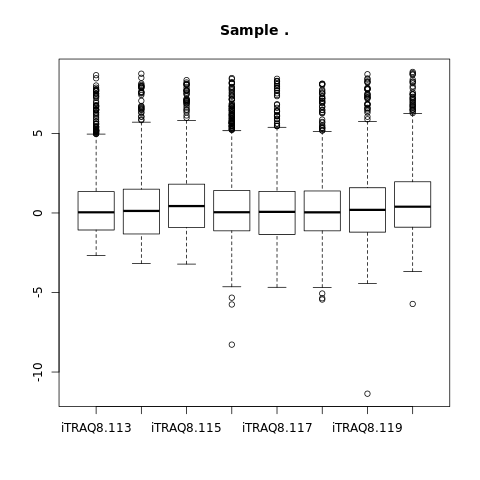

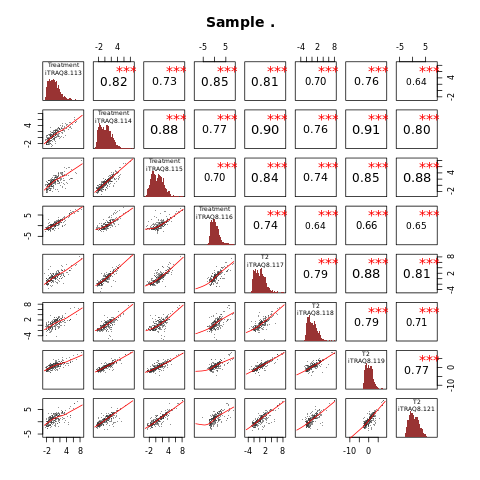

In [133]:
%%R


# TODO read experimental design
ExpDesign <- read.table("/home/biodocker/OUT/exp_design.tsv")


panel.cor <- function(x, y, digits=2, prefix="", cex.cor, ...) 
{
    usr <- par("usr"); on.exit(par(usr)) 
    par(usr = c(0, 1, 0, 1)) 
    r <- abs(cor(x, y, use="na.or.complete")) 
    txt <- format(c(r, 0.123456789), digits=digits)[1] 
    txt <- paste(prefix, txt, sep="") 
    cex.cor <- 0.8/strwidth(txt) 
    test <- cor.test(x,y) 
    # borrowed from printCoefmat
    Signif <- symnum(test$p.value, corr = FALSE, na = FALSE, 
                  cutpoints = c(0, 0.001, 0.01, 0.05, 0.1, 1),
                  symbols = c("***", "**", "*", ".", " ")) 
 
    text(0.5, 0.5, txt, cex = cex.cor * r) 
    text(.8, .8, Signif, cex=cex.cor, col=2) 
}

panel.hist <- function(x, hist.col="#993333", ...)
{
    usr <- par("usr"); on.exit(par(usr))
   par(usr = c(usr[1:2], 0, 1.5) )
    h <- hist(x, plot = FALSE, border=NA,breaks=50)
    breaks <- h$breaks; nB <- length(breaks)
  y <- h$counts; y <- y/max(y)
    rect(breaks[-nB], 0, breaks[-1], y,col=hist.col,border=NA)
}


for (s in samples) {
    allqnt <- PSMDat[[s]]
    
    condNames <- ExpDesign[ExpDesign[,2] == unique(ExpDesign[,2])[which(s==samples)],1]
    condNames <- paste(condNames, sampleNames(allqnt), sep="\n")
    pData(allqnt)$sample_name <- paste(condNames, sampleNames(allqnt))
pData(allqnt)$sample_group <- condNames
    
    
    #print(pData(allqnt))
    
    ## QC Plots
  boxplot(exprs(allqnt), main =paste("Sample",s), labels =  condNames)

    
  pairs(exprs(allqnt),lower.panel=panel.smooth, upper.panel=panel.cor, diag.panel=panel.hist, main = paste("Sample",s),
cex=0.1,col="#33333388",pch=15, labels =  condNames)
    
  #print(fData(allqnt))  
}

    


In [134]:
%%R

print("PSM filtering and impurity correction")

for (s in samples) {
    allqnt <- PSMDat[[s]]

imp<-makeImpuritiesMatrix(length(quant.method),edit=F)
  for (i in 1:length(qnt)) {
    qnt[[i]] <- purityCorrect(qnt[[i]],imp)
    exprs(qnt[[i]]) <- log2(exprs(qnt[[i]]))
    qnt[[i]] <- normalise(qnt[[i]],"center.median")
    qnt[[i]] <- updateFeatureNames(qnt[[i]],label = paste("Sample",i))
  }
      
  names(qnt) <- NULL
  allqnt <- do.call("combine",args=qnt)
      
  allqnt <- filterNA(allqnt, pNA=0.5)


  ## Setting the stage for the iPQF inference method
  names(fData(allqnt))[which(names(fData(allqnt))=="Protein.s.")] <- "accession"
  names(fData(allqnt))[which(names(fData(allqnt))=="Variable.Modifications")] <- "modifications"
  names(fData(allqnt))[which(names(fData(allqnt))=="m.z")] <- "mass_to_charge"
  names(fData(allqnt))[which(names(fData(allqnt))=="Confidence....")] <- "search_engine_score"
    head(allqnt)
    
}

[1] "PSM filtering and impurity corrrection"


[1] "Protein inference ...\n"
[1] "Sample ."
Your data contains missing values. Please read the relevant section in
the combineFeatures manual page for details the effects of missing
values on data aggregation.


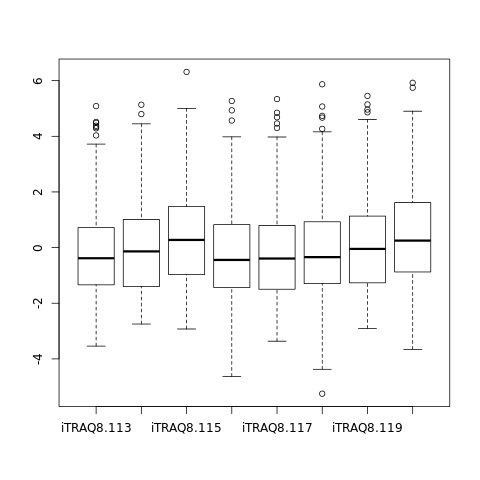

In [155]:
%%R

print("Protein inference ...\n")    

for (s in samples) {

    load(paste("/home/biodocker/OUT/",s,"/AllQuantPSMs.RData",sep=""))
exprs(allqnt) <- 2^exprs(allqnt)

print(paste("Sample",s))
    
    
  #Problem: iPQF does not seem to work with missing values!
  allProts <- combineFeatures(allqnt, groupBy=fData(allqnt)$accession, fun="medpolish",verbose=F, na.rm=T)
 exprs(allProts) <- log2(exprs(allProts))
   
    
#  print(head(exprs(allProts)))
    
  boxplot(exprs(allProts))
    
  #stop("")
  #pairs(exprs(allProts))
  #save
  write.exprs(allProts,file=paste("/home/biodocker/OUT/",s,"/AllQuantProteins.csv",sep=""))
  
  ProtDat[[s]] <- allProts <- exprs(allProts)
    colnames(ProtDat[[s]]) <- condNames
  
}


[1] "Merging samples (if needed) ..."
[1] "Quantified a total of 1023 protein groups"


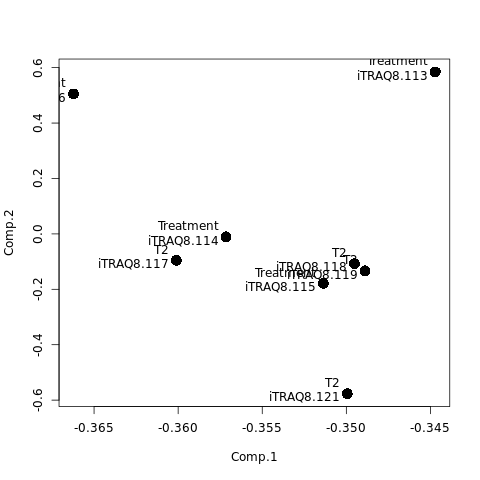

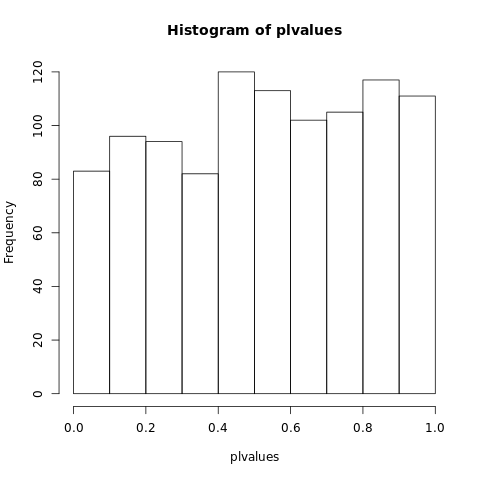

In [156]:
%%R 

print("Merging samples (if needed) ...")

# Merge different samples
    totProts <- ProtDat[[1]]
if (length(samples)>1) {
    for (s in samples[2:length(samples)])
    totProts <- merge(totProts,ProtDat[[s]], all=T, by.x=1, by.y=0)
} 

write.csv(totProts,file=paste("/home/biodocker/OUT/AllQuantProteinsInAllSamples.csv",sep=""))

# PCA
  pca <- princomp(totProts[complete.cases((totProts)),])
  #plot(pca)
  plot(pca$loadings, cex=2, pch=16)
  text(pca$loadings,colnames(totProts), pos=2)
    
  print(paste("Quantified a total of",nrow(allProts),"protein groups"))



##Statistics
library(limma)
#library(qvalue)
NumCond <- length(unique(ExpDesign[,1]))
  if (NumCond < 2)
      stop("Only 1 experimental condition -> no statistics")

design <- model.matrix(~0+factor(ExpDesign[,1])-1)
  colnames(design)<-paste("i",unique(ExpDesign[,1]),sep="")
  contrasts<-NULL
  First <- 1
  for (i in (1:NumCond)[-First]) contrasts<-append(contrasts,paste(colnames(design)[i],"-",colnames(design)[First],sep=""))
  contrast.matrix<-makeContrasts(contrasts=contrasts,levels=design)
  # print(dim(Data))
  lm.fitted <- lmFit(totProts,design)
  lm.contr <- contrasts.fit(lm.fitted,contrast.matrix)
  lm.bayes<-eBayes(lm.contr)
  topTable(lm.bayes)
    hist(plvalues)
  qlvalues <- matrix(NA,nrow=nrow(plvalues),ncol=ncol(plvalues),dimnames=dimnames(plvalues))
  # qvalue correction
#  for (i in 1:ncol(plvalues)) {
#    tqs <- qvalue(na.omit(plvalues[,i]))$qvalues
#    qlvalues[names(tqs),i] <- tqs
#  }
  
# Visualizations: volcano plot, number of regulated proteins per FDR, interactive table?


# How far should we go? Clustering (when having more then 2 groups)? 
# Hierarchical clustering of significant features? clusterProfiler?



In [157]:
%%R

# test ground for interactive apps
library(plotly)
library(reshape)

dp <- ggplot(melt(allProts), aes(x=variable, y=value)) + 
  geom_violin(trim=FALSE)+
  geom_boxplot(width=0.1, fill="white")+
  dp + theme_classic()

x <- rnorm(1000)
y <- rchisq(1000, df = 1, ncp = 0)
group <- sample(LETTERS[1:5], size = 1000, replace = T)
size <- sample(1:5, size = 1000, replace = T)

ds <- data.frame(x, y, group, size)

p <- plot_ly(ds, x = x, y = y, mode = "markers", split = group, size = size) %>%
  layout(title = "Scatter Plot")
embed_notebook(p)
print(p)

Error in library(reshape) : there is no package called 'reshape'
In addition: There were 20 warnings (use warnings() to see them)
Error in library(reshape) : there is no package called 'reshape'
